# Face Alignment And Stabilization Using Dlib

## Import Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/App/EVA/Session18/models' /content
!cp -r '/content/drive/My Drive/App/EVA/Session18/videos' /content
!cp -r '/content/drive/My Drive/App/EVA/Session18/images' /content
!cp '/content/drive/My Drive/App/EVA/Session18/faceBlendCommon.py' /content

## Import Packages

In [0]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import faceBlendCommon as fbc
%matplotlib inline
 

import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## Utilities

In [0]:
import os

In [0]:
# save all images to disk
def save_all_images(path, filename, imageList):
  for cnt in range(0, len(imageList)):
    temp_fn = filename + '_' + str(cnt) + '.png'
    fn = os.path.join(path) + os.path.join(temp_fn)
    cv2.imwrite(fn, imageList[cnt])

## Process Video into Frames

In [0]:
# process the video frame by frame
cap = cv2.VideoCapture('/content/videos/NewsFeedTrim3.mp4')

all_frames = []
while(cap.isOpened()):
    ret, frame = cap.read()

    if frame is None:
      break

    all_frames.append(frame)
    #plt.imshow(frame)

cap.release()

In [7]:
len(all_frames)

153

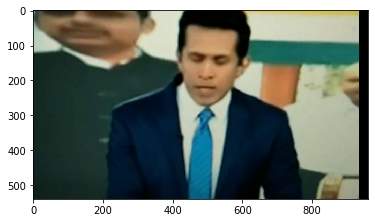

In [8]:
plt.imshow(all_frames[0][:,:,::-1])

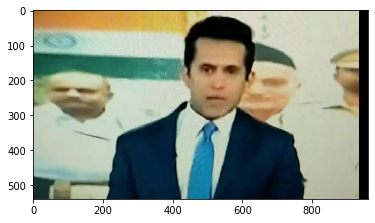

In [9]:
plt.imshow(all_frames[100][:,:,::-1])

In [0]:
os.mkdir('/content/results')

In [0]:
os.mkdir('/content/results/original')

In [0]:
save_all_images('/content/results/original/', 'frame', all_frames)

## Align Faces Using 5 Point Landmark Detector

### Get the model for 5 point landmark detector

In [0]:
# Landmark model location
MODEL_PATH = '/content/models/'
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_5_face_landmarks.dat"

### Initialize Face Detector

In [0]:
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()

# The landmark detector is implemented in the shape_predictor class
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

### Align Faces

In [0]:
# get the aligned face
def get_aligned_face(im):
  # Detect faces in the image
  faceRects = faceDetector(im, 0)
  #print("Number of faces detected: ",len(faceRects))

  # Detect landmarks.
  points = fbc.getLandmarks(faceDetector, landmarkDetector, im)

  #len(points)

  points = np.array(points)
  # Convert image to floating point in the range 0 to 1
  im = np.float32(im)/255.0

  # Dimensions of output image
  h = 600
  w = 600

  # Normalize image to output coordinates.
  imNorm, points = fbc.normalizeImagesAndLandmarks((h, w), im, points)

  imNorm = np.uint8(imNorm*255)
  return imNorm

In [16]:
len(all_frames)

153

In [17]:
# Get aligned faces for all frames.
all_aligned_faces = []

print('Aligning all frames... ')
# process one frame at a time. 
for cnt in range(0, len(all_frames)):
  frame = all_frames[cnt]
  aligned_face = get_aligned_face(frame)
  all_aligned_faces.append(aligned_face)

print('Done!')

Aligning all frames... 
Done!


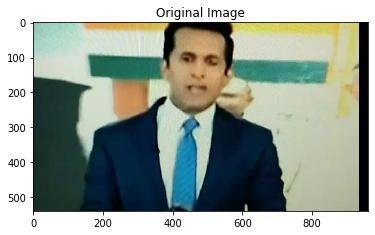

In [18]:
# Display the results
plt.imshow(all_frames[50][:,:,::-1])
plt.title("Original Image")
plt.show()

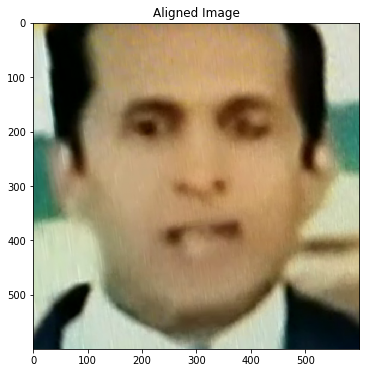

In [19]:
# Display the results
plt.imshow(all_aligned_faces[50][:,:,::-1])
plt.title("Aligned Image")
plt.show()

In [0]:
os.mkdir('/content/results/align_faces')

In [0]:
save_all_images('/content/results/align_faces/', 'align_face', all_aligned_faces)

In [0]:
#!cp -r /content/results '/content/drive/My Drive/App/EVA/Session18'

## Stabilize Landmarks Points

### Calculate the 68 point landmark on Aligned Face.

In [0]:
MODEL_PATH = '/content/models/'
PREDICTOR_PATH = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

In [0]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [0]:
winName = "Stabilized facial landmark detector"

In [0]:
videoFileName = "/content/videos/NewsFeedTrim3.mp4"

# Initializing video capture object.
cap = cv2.VideoCapture(videoFileName)

if(cap.isOpened()==False):
  print("Unable to load video")

### Parameters for Lucas Kanade Method

In [0]:
import math
from google.colab.patches import cv2_imshow

In [0]:
winSize = 101
maxLevel = 10
fps = 30.0
# Grab a frame
ret,imPrev = cap.read()

In [0]:
# Finding the size of the image.
size = imPrev.shape[0:1]

In [30]:
print(size)
print(imPrev.shape)

(540,)
(540, 960, 3)


In [0]:
# initialize the face detector
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

In [0]:
# Initializing the parameters
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

In [0]:
eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count =0

In [0]:
all_stabilized_frames = []

In [35]:
while(True):
  if (count==0):
    t = cv2.getTickCount()

  # Grab a frame
  ret,im = cap.read()
  if im is None:
    break
    
  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # COnverting to grayscale
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  imGrayPrev = imGray
  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
  # Resize image for faster face detection
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
  # Skipping the frames for faster processing
  if (count % SKIP_FRAMES == 0):
    faces = detector(imSmallDlib,0)

  # If no face was detected
  if len(faces)==0:
    print("No face detected")

  # If faces are detected, iterate through each image and detect landmark points
  else:
    for i in range(0,len(faces)):
      print("face detected")
      # Face detector was found over a smaller image.
      # So, we scale face rectangle to correct size.
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))
      
      # Detect landmarks in current frame
      landmarks = landmarkDetector(imDlib, newRect).parts()
      
      # Handling the first frame of video differently,for the first frame copy the current frame points
      
      if (isFirstFrame==True):
        pointsPrev=[]
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

      # If not the first frame, copy points from previous frame.
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur

      # pointsDetectedCur stores results returned by the facial landmark detector
      # points stores the stabilized landmark points
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

      # Convert to numpy float array
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)

      # If eye distance is not calculated before
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)
        print(eyeDistance)
        eyeDistanceNotCalculated = False

      if eyeDistance > 100:
          dotRadius = 3
      else:
        dotRadius = 2

      print(eyeDistance)
      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1

      #  Set up optical flow params
      lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
      # ret, imGrayPyr= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)

      pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)
      

      # Converting to float
      pointsArrFloat = np.array(pointsArr,np.float32)

      # Converting back to list
      points = pointsArrFloat.tolist()

      # Final landmark points are a weighted average of
      # detected landmarks and tracked landmarks
      for k in range(0,len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

      # Drawing over the stabilized landmark points
      if showStabilized is True:
        for p in points:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
      else:
        for p in pointsDetectedCur:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)

      isFirstFrame = False
      count = count+1

      # Calculating the fps value
      if ( count == NUM_FRAMES_FOR_FPS):
        t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
        fps = NUM_FRAMES_FOR_FPS/t
        count = 0
        isFirstFrame = True

      # Display the landmarks points
      cv2.putText(im, "{:.1f}-fps".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3,cv2.LINE_AA)
      #cv2.imshow(winName, im)
      #cv2_imshow(im)
      # key = cv2.waitKey(25) & 0xFF

      # # Use spacebar to toggle between Stabilized and Unstabilized version.
      # if key==32:
      #   showStabilized = not showStabilized

      # # Stop the program.
      # if key==27:
      #   sys.exit()

      all_stabilized_frames.append(im)

      # Getting ready for next frame
      imPrev = im
      imGrayPrev = imGray

#cv2.destroyAllwindows()
cap.release()

face detected
91
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detected
91
face detect

In [36]:
len(all_stabilized_frames)

152

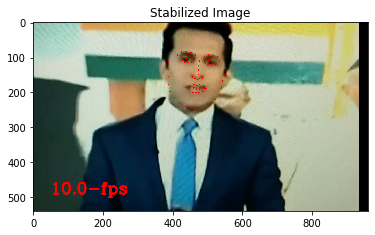

In [37]:
# Display the results
plt.imshow(all_stabilized_frames[50][:,:,::-1])
plt.title("Stabilized Image")
plt.show()

In [0]:
# There is no previous info for the frist frame.
# Inorder to make video, we want to have the total number of frames equal.
# so, just insert the first stabilized video frame as zeroth entry as well.
all_stabilized_frames.insert(0, all_stabilized_frames[0])

In [39]:
len(all_stabilized_frames)

153

In [0]:
os.mkdir('/content/results/stab_frames')

In [0]:
save_all_images('/content/results/stab_frames/', 'stab_frame', all_stabilized_frames)

In [0]:
!cp -r /content/results '/content/drive/My Drive/App/EVA/Session18'

In [0]:
#!cp -r /content/results '/content/drive/My Drive/App/EVA'